In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read in the data. Enter trans_date_trans_time as a datetime object.

In [80]:
raw = pd.read_csv('raw_data/fraud_data.csv', index_col=0, parse_dates=['trans_date_trans_time', 'dob'], infer_datetime_format=True)
raw.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:00,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:00,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:00,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0


In [81]:
print(raw.shape)

(555719, 22)


In [82]:
raw.dtypes

trans_date_trans_time    datetime64[ns]
cc_num                          float64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
dtype: object

Check for missing values.

In [83]:
nulls = raw.isna().sum()
nulls[nulls!=0]

Series([], dtype: int64)

In [84]:
raw[['is_fraud']].value_counts(normalize=True)*100

is_fraud
0           99.614014
1            0.385986
dtype: float64

Text(0.5, 1.0, 'Real vs. Fraudulent Transactions')

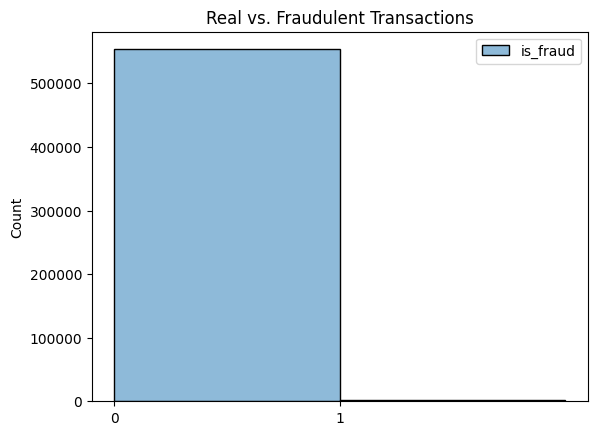

In [85]:
sns.histplot(raw[['is_fraud']],bins=[0,1,2], edgecolor='black')
plt.xticks([0,1])
plt.title('Real vs. Fraudulent Transactions')

This dataset is extremely imbalanced. It is 99.6% real and only 0.4% fraudulent transactions.

In [39]:
raw['merchant'].nunique()

693

In [45]:
raw['category'].unique()

array(['personal_care', 'health_fitness', 'misc_pos', 'travel',
       'kids_pets', 'shopping_pos', 'food_dining', 'home',
       'entertainment', 'shopping_net', 'misc_net', 'grocery_pos',
       'gas_transport', 'grocery_net'], dtype=object)

In [49]:
raw[raw['is_fraud']==1].category.value_counts(normalize=True)*100

shopping_net      23.589744
grocery_pos       22.610723
misc_net          12.447552
shopping_pos       9.930070
gas_transport      7.179487
misc_pos           3.356643
personal_care      3.263403
home               3.123543
kids_pets          3.030303
entertainment      2.750583
food_dining        2.517483
health_fitness     2.424242
grocery_net        1.911422
travel             1.864802
Name: category, dtype: float64

Text(0.5, 1.0, 'Distribution of Transaction Types Among Fraudulent Transactions')

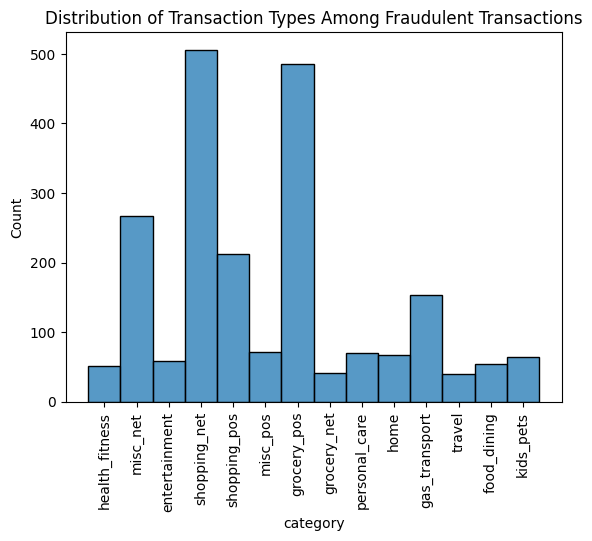

In [54]:
sns.histplot(raw[raw['is_fraud']==1].category)
plt.xticks(rotation=90)
plt.title('Distribution of Transaction Types Among Fraudulent Transactions')

It looks like internet shopping is the most common fraudulent transaction type.

In [41]:
raw['cc_num'].nunique()

904

It looks like we have 904 different credit cards in this dataset.

In [44]:
raw['job'].nunique()

478

# Feature Engineering and Encoding

Ideas:
1. Cardholder age = transaction_date - DOB
2. OneHotEncode transaction category
3. Encode gender


Drop:
1. Date and time after calculating age
2. merchant (because there are 693 of them. Will make feature set too high dimensional)
3. CC_num (the actual cc number will likely not give us any useful information)
4. First and last name
5. street, city, state, zip (these should all be covered by lag and long)
6. job - I think this column could potentially provide us with some useful information, but it contains 478 different jobs. Encoding it could expand our dataset into too many dimensions.
7. dob after getting age
8. trans_num
9. unix_time - it seems to contain the same information as transaction_date_and_time

In [86]:
def get_age(df):
    """Takes in a padas df and computes a customer_age column. Returns original
    dataframe with this new column added."""
    df['customer_age'] = np.floor((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1, 'Y'))
    return df

In [87]:
raw = get_age(raw)

In [88]:
clean = raw.drop(columns=[
    'trans_date_trans_time', 'cc_num', 'merchant',
    'first', 'last', 'street', 'city',
    'state', 'zip', 'job',
    'dob', 'trans_num', 'unix_time'])

Text(0.5, 1.0, 'Customer Ages')

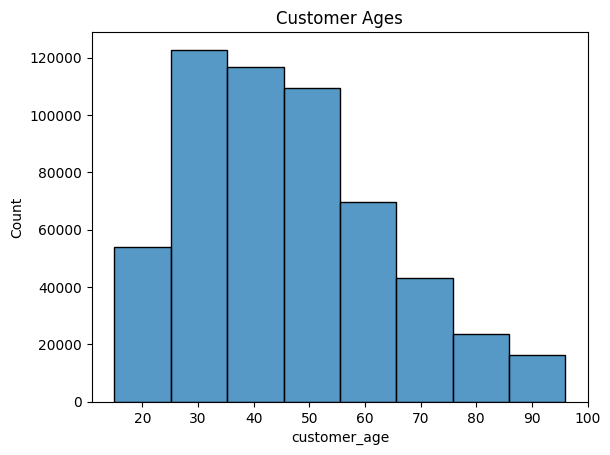

In [94]:
sns.histplot(clean['customer_age'], bins=8)
plt.title('Customer Ages')

In [89]:
clean.sample(2)

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,customer_age
86829,shopping_net,110.10,M,31.6143,-82.7243,782,31.494135,-82.574679,0,38.0
58053,kids_pets,33.55,M,44.0575,-69.9656,3224,43.741531,-69.683019,0,22.0


In [95]:
clean.dtypes

category         object
amt             float64
gender           object
lat             float64
long            float64
city_pop          int64
merch_lat       float64
merch_long      float64
is_fraud          int64
customer_age    float64
dtype: object

Let's save the processed dataframe to a csv that we can use in a seperate model notebook.

In [106]:
clean.to_csv('processed_data/fraud_data_processed.csv')